In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
sns.set(style="whitegrid", palette="muted", context="notebook")
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = False

In [5]:
df = pd.read_csv('insurance.csv')

In [8]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [11]:
print(f"Missing values:\n{df.isnull().sum()}")
print("\nDescriptive statistics:\n", df.describe(include='all'))

Missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Descriptive statistics:
                 age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5

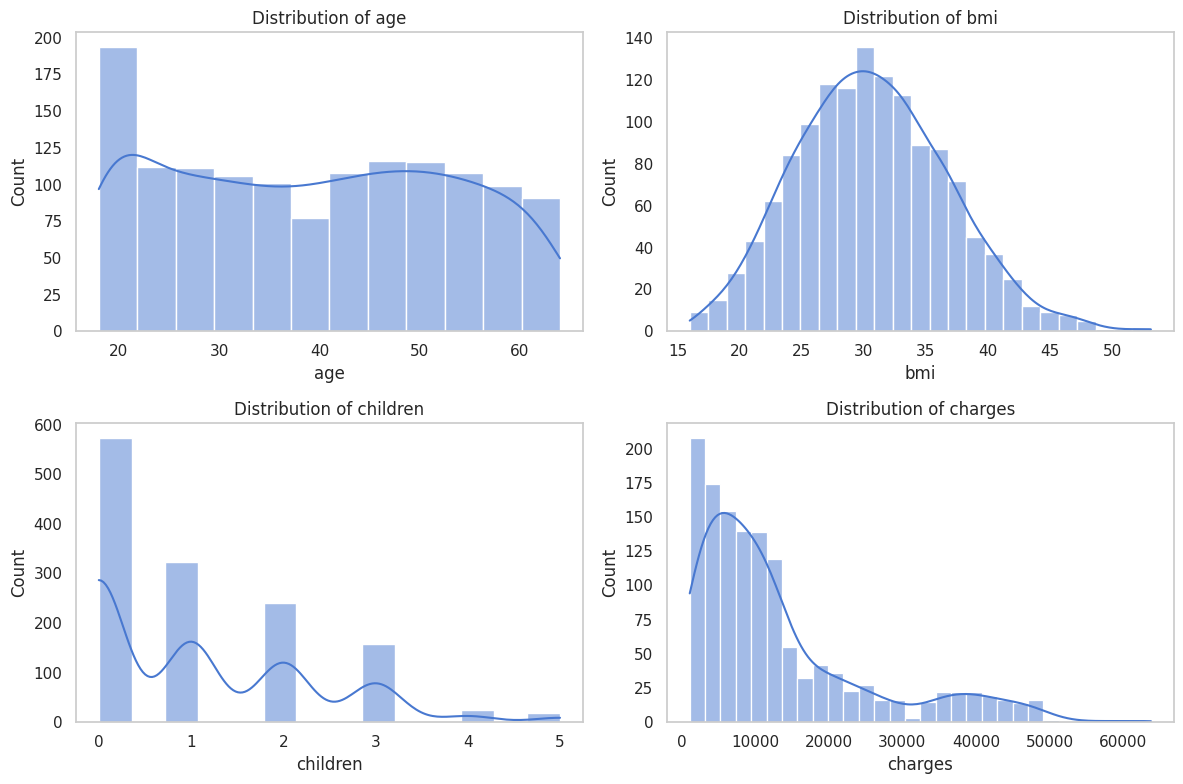

In [12]:
num_cols = ['age', 'bmi', 'children', 'charges']
fig, axs = plt.subplots(2,2, figsize=(12,8))
for ax, col in zip(axs.ravel(), num_cols):
    sns.histplot(df[col], kde=True, ax=ax, color='C0')
    ax.set_title(f"Distribution of {col}")
plt.tight_layout(); plt.show()

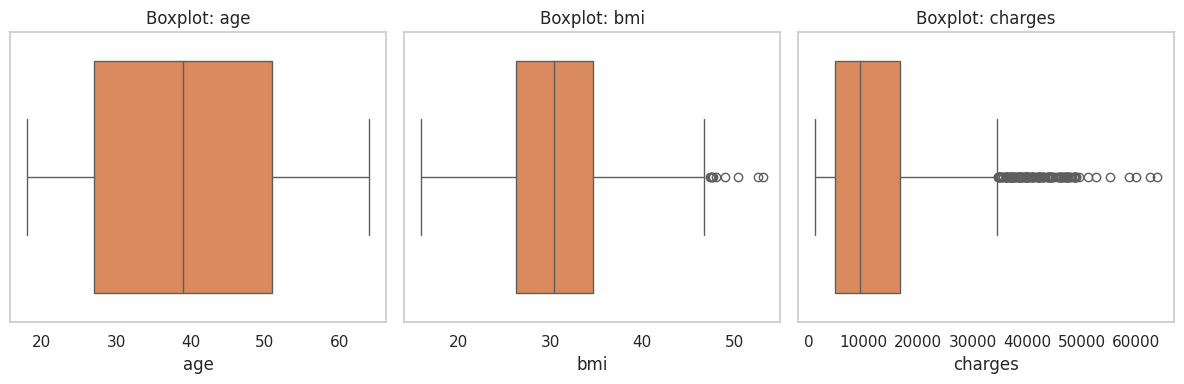

In [13]:
plt.figure(figsize=(12,4))
for i, col in enumerate(['age','bmi','charges']):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=df[col], color='C1')
    plt.title(f"Boxplot: {col}")
plt.tight_layout(); plt.show()

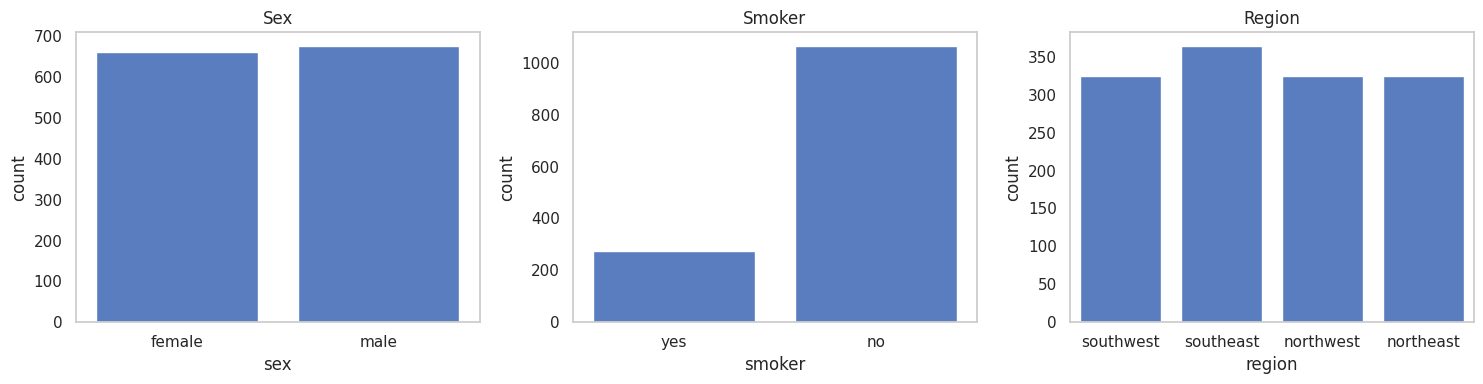

In [14]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.countplot(x='sex', data=df, ax=axs[0])
sns.countplot(x='smoker', data=df, ax=axs[1])
sns.countplot(x='region', data=df, ax=axs[2])
axs[0].set_title('Sex'); axs[1].set_title('Smoker'); axs[2].set_title('Region')
plt.tight_layout(); plt.show()

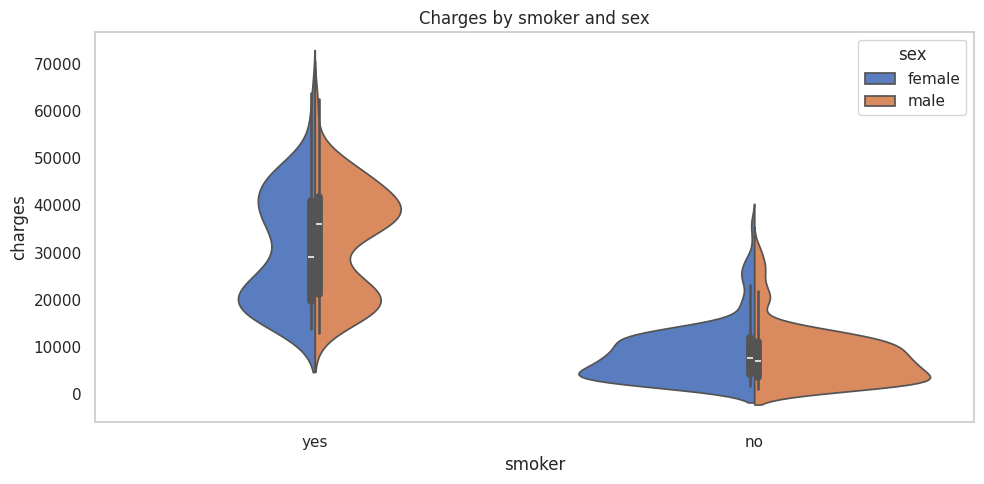

In [15]:
plt.figure(figsize=(10,5))
sns.violinplot(x='smoker', y='charges', hue='sex', data=df, split=True)
plt.title("Charges by smoker and sex")
plt.tight_layout(); plt.show()

In [16]:
df_enc = df.copy()
df_enc['sex'] = (df_enc['sex'] == 'male').astype(int)
df_enc['smoker'] = (df_enc['smoker'] == 'yes').astype(int)
df_enc = pd.get_dummies(df_enc, columns=['region'], drop_first=True)  # avoid dummy trap

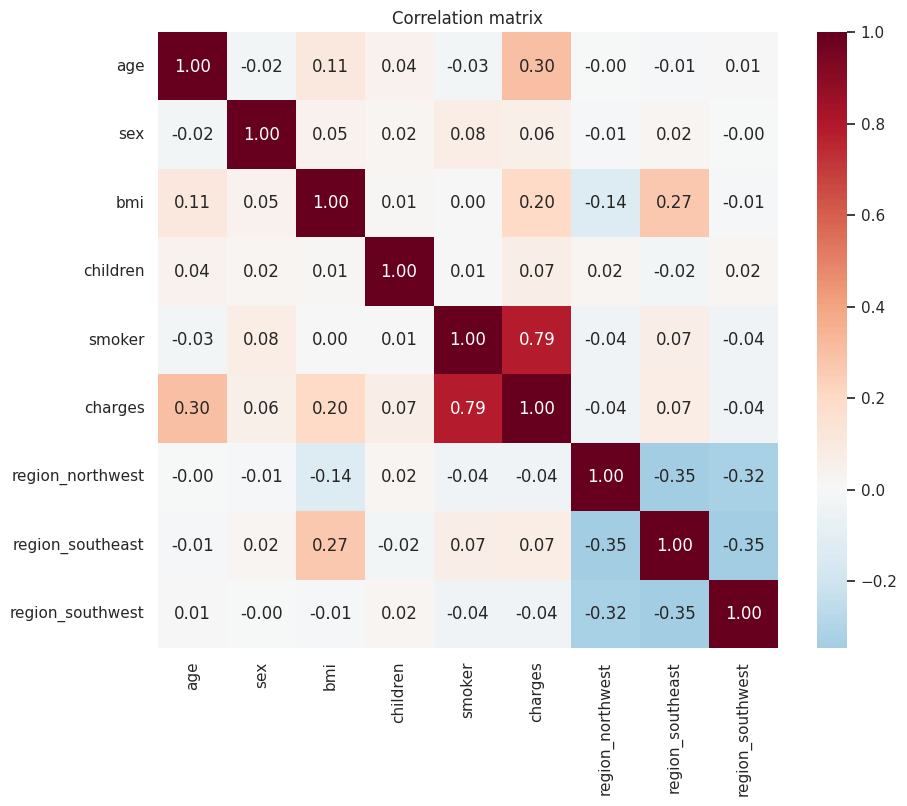

In [17]:
corr = df_enc.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title("Correlation matrix")
plt.show()

In [18]:
corr_with_target = corr['charges'].drop('charges').sort_values(key=lambda s: s.abs(), ascending=False)
print("\nCorrelation with charges (by absolute value):\n", corr_with_target)


Correlation with charges (by absolute value):
 smoker              0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex                 0.057292
region_southwest   -0.043210
region_northwest   -0.039905
Name: charges, dtype: float64


/tmp/ipython-input-2475820409.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')


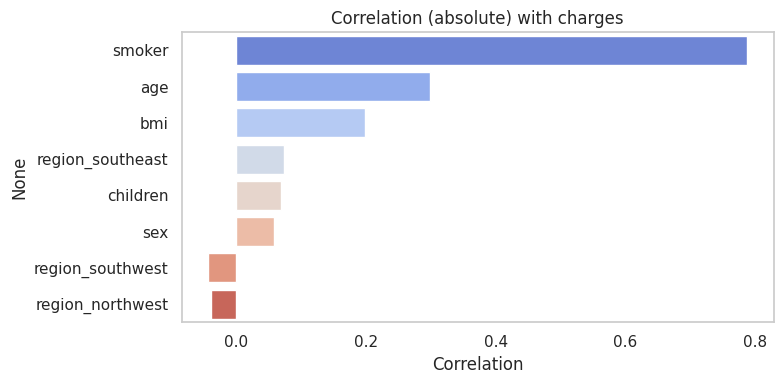

In [19]:
plt.figure(figsize=(8,4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
plt.title("Correlation (absolute) with charges")
plt.xlabel("Correlation")
plt.tight_layout(); plt.show()

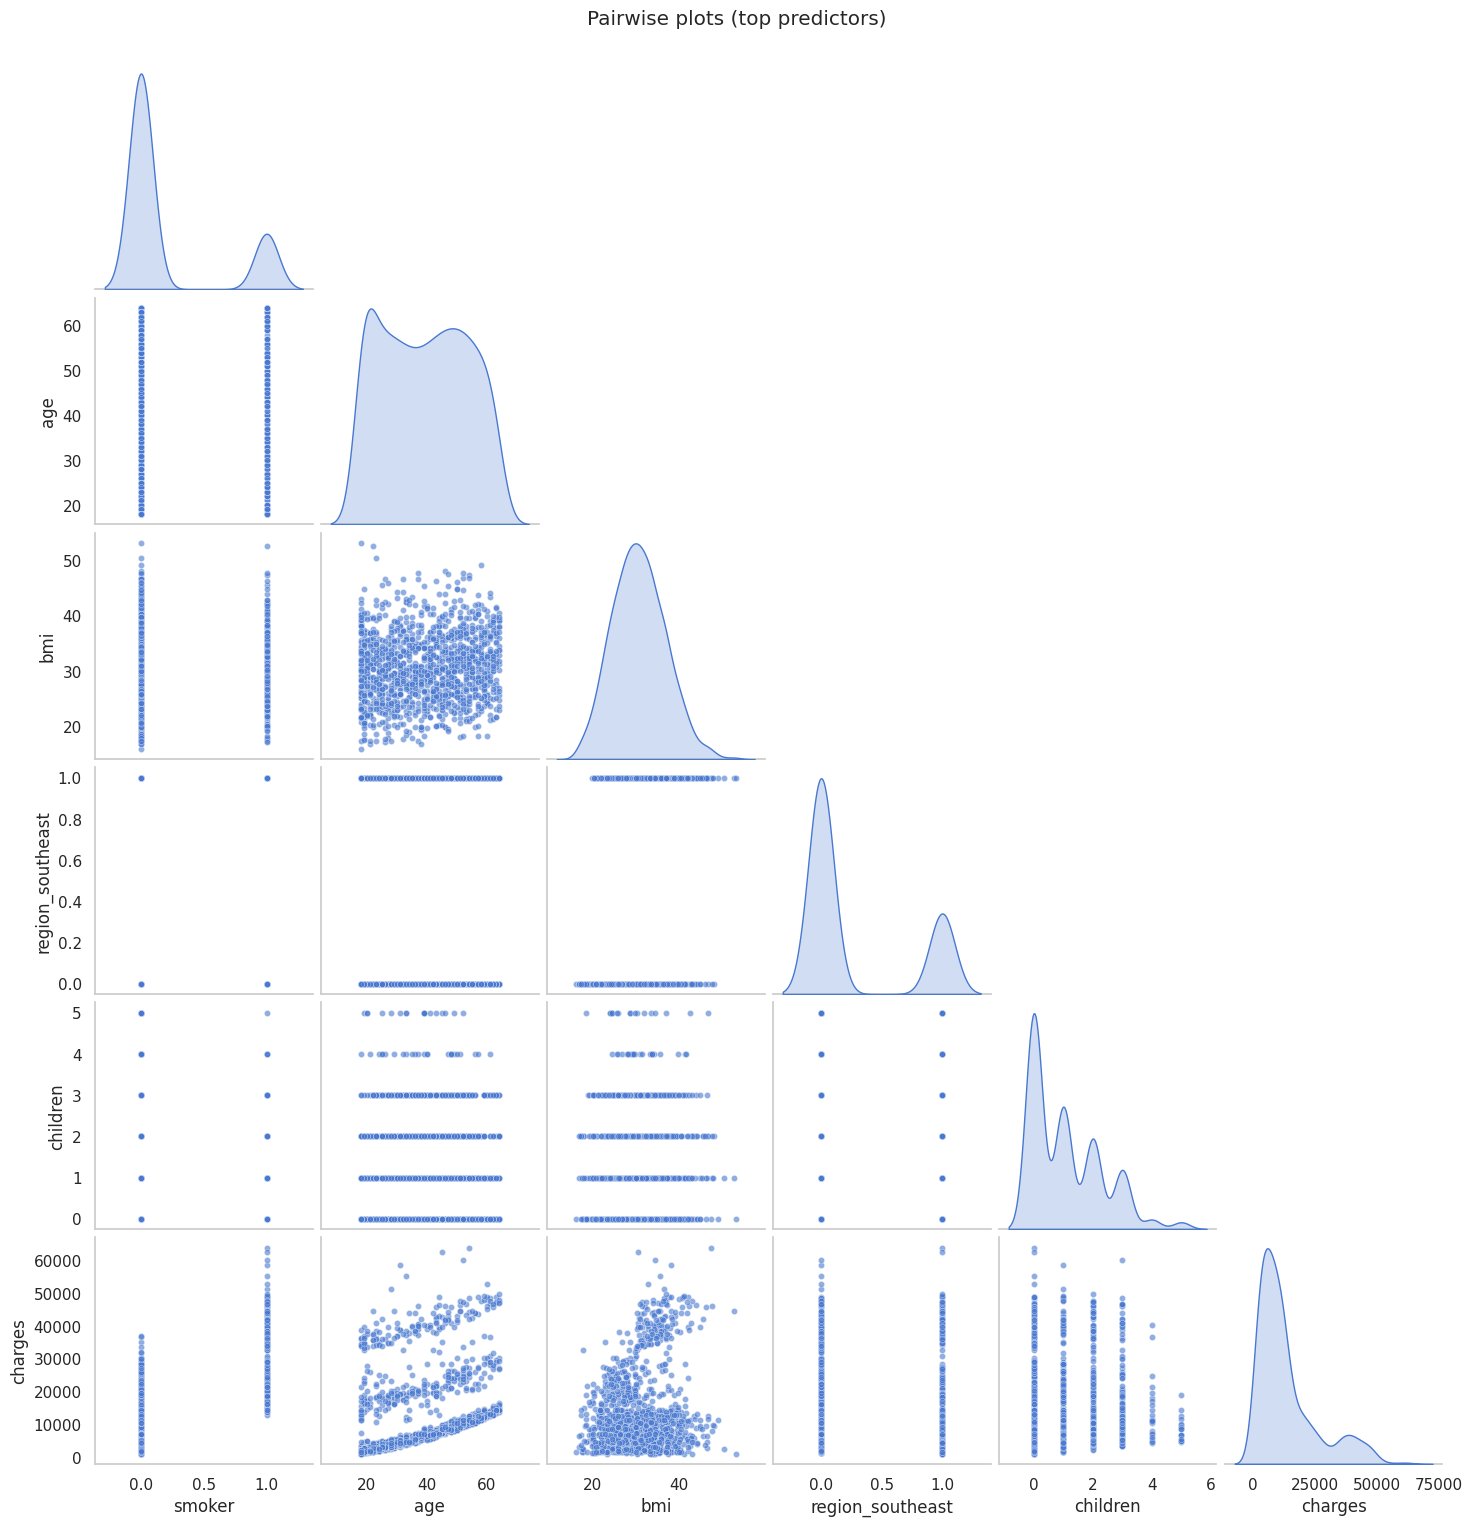

In [20]:
top_feats = corr_with_target.abs().sort_values(ascending=False).index[:5].tolist()
pair_cols = top_feats + ['charges']
sns.pairplot(df_enc[pair_cols], corner=True, diag_kind='kde', plot_kws={'s':20, 'alpha':0.6})
plt.suptitle("Pairwise plots (top predictors)", y=1.02)
plt.show()

In [21]:
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

for col in ['age','bmi','children','charges']:
    outs = iqr_outliers(df[col])
    print(f"{col}: {len(outs)} outliers (IQR)")

age: 0 outliers (IQR)
bmi: 9 outliers (IQR)
children: 0 outliers (IQR)
charges: 139 outliers (IQR)


In [25]:
y = df_enc['charges'].values.reshape(-1,1)
X = df_enc.drop(columns=['charges']).values
feature_names = ['intercept'] + list(df_enc.drop(columns=['charges']).columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_all = np.hstack([np.ones((X_scaled.shape[0],1)), X_scaled])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [30]:
def analytic_solution(X, y):
    XtX = X.T.dot(X)
    Xty = X.T.dot(y)
    theta = np.linalg.pinv(XtX).dot(Xty)
    return theta

theta_analytic = analytic_solution(X_train, y_train)
print(f"Analytic theta: {theta_analytic}")

Analytic theta: [[ 1.33143359e+04]
 [ 3.60914902e+03]
 [-9.29533694e+00]
 [ 2.05488506e+03]
 [ 5.12478869e+02]
 [ 9.54425109e+03]
 [-1.58959435e+02]
 [-2.92759080e+02]
 [-3.47270359e+02]]


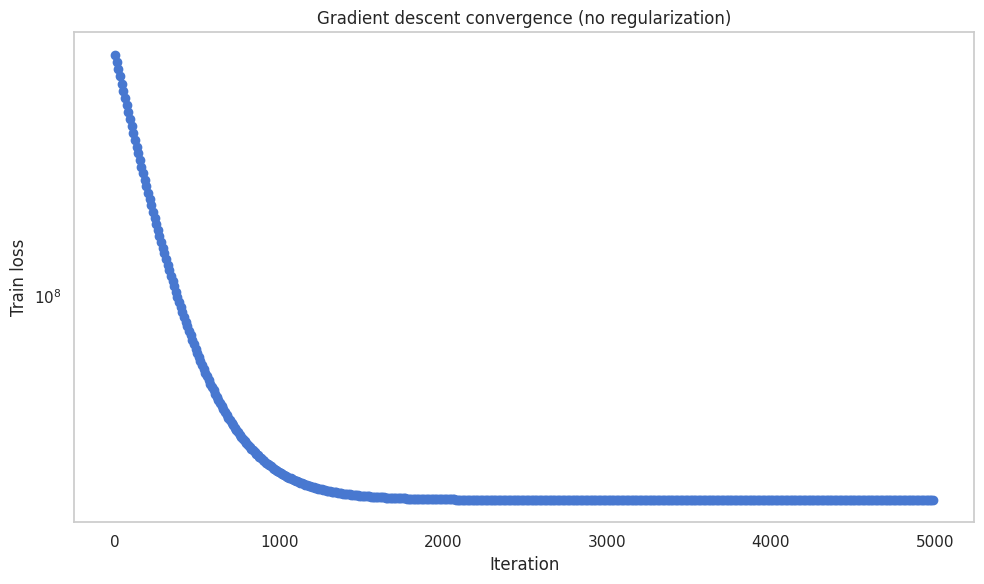

In [54]:
def gradient_descent_trace(X, y, lr=1e-3, n_iters = 100, tol=1e-9, lam=0.0, trace_every=100):
    n, m = X.shape
    theta = np.zeros((m,1))
    losses = []
    iters = []
    for it in range(n_iters):
        preds = X.dot(theta)
        error = preds - y
        loss = (error**2).mean() + lam * (theta[1:]**2).mean()
        grad = (2.0/n) * X.T.dot(error)
        if lam > 0:
            grad += 2 * lam * np.vstack([[[0.0]], theta[1:]]) / m
        theta -= lr * grad
        if it % trace_every == 0:
            losses.append(loss)
            iters.append(it)
    return theta, np.array(iters), np.array(losses)

theta_gd, gd_iters, gd_losses = gradient_descent_trace(X_train, y_train, lr=1e-3, n_iters=5000, trace_every=10)
plt.plot(gd_iters, gd_losses, marker='o')
plt.yscale('log')
plt.xlabel("Iteration"); plt.ylabel("Train loss")
plt.title("Gradient descent convergence (no regularization)")
plt.tight_layout(); plt.show()

In [55]:
def ridge_cv_mse(X, y, lambdas, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    mean_mses = []
    for lam in lambdas:
        mses = []
        for train_idx, val_idx in kf.split(X):
            Xt, Xv = X[train_idx], X[val_idx]
            yt, yv = y[train_idx], y[val_idx]
            th = analytic_ridge(Xt, yt, lam)
            mses.append(mean_squared_error(yv, Xv.dot(th)))
        mean_mses.append(np.mean(mses))
    return np.array(mean_mses)

lambdas = np.logspace(-5, 5, 50)
cv_mses = ridge_cv_mse(X_train, y_train, lambdas, k=5)
best_lambda = float(lambdas[np.argmin(cv_mses)])
print("Best lambda (5-fold CV):", best_lambda)

Best lambda (5-fold CV): 3.2374575428176464


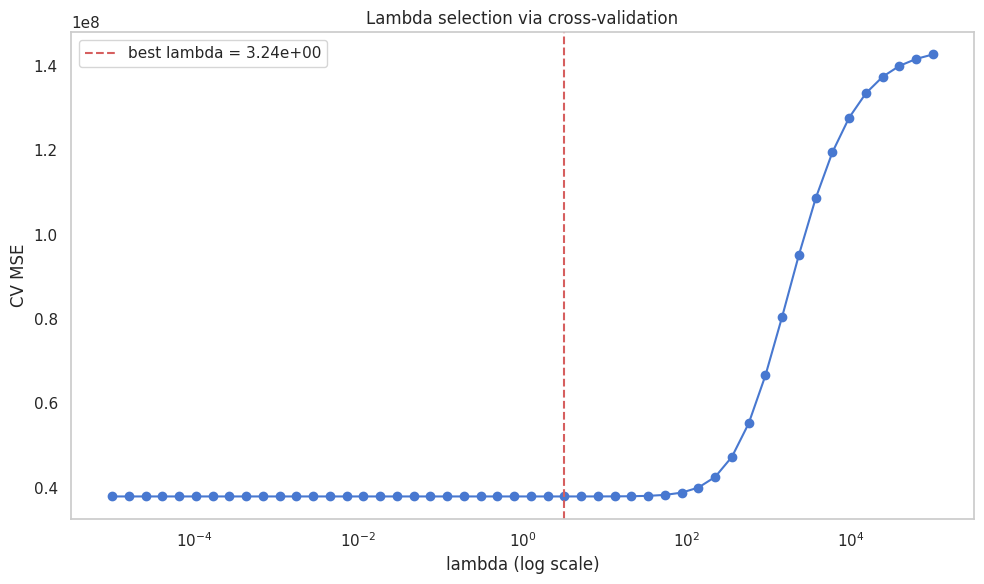

In [56]:
plt.semilogx(lambdas, cv_mses, marker='o')
plt.axvline(best_lambda, color='C3', linestyle='--', label=f'best lambda = {best_lambda:.2e}')
plt.xlabel("lambda (log scale)"); plt.ylabel("CV MSE")
plt.title("Lambda selection via cross-validation")
plt.legend(); plt.tight_layout(); plt.show()

theta_ridge = analytic_ridge(X_train, y_train, best_lambda)

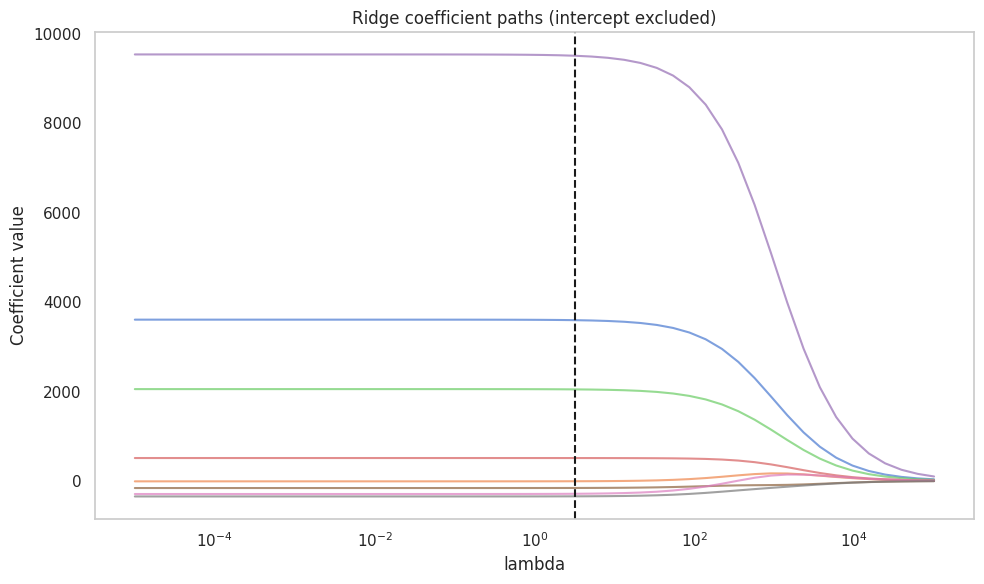

In [57]:
coef_paths = []
for lam in lambdas:
    th = analytic_ridge(X_train, y_train, lam).flatten()
    coef_paths.append(th[1:])
coef_paths = np.vstack(coef_paths)

plt.figure(figsize=(10,6))
for i in range(coef_paths.shape[1]):
    plt.plot(lambdas, coef_paths[:,i], alpha=0.7)
plt.xscale('log')
plt.xlabel("lambda"); plt.ylabel("Coefficient value")
plt.title("Ridge coefficient paths (intercept excluded)")
plt.axvline(best_lambda, color='k', linestyle='--')
plt.tight_layout(); plt.show()

In [58]:
y_mean = y_train.mean()
y_const_pred = np.full_like(y_test, y_mean)

y_pred_analytic = X_test.dot(theta_analytic)
y_pred_gd = X_test.dot(theta_gd)
y_pred_ridge = X_test.dot(theta_ridge)

mse_const = mean_squared_error(y_test, y_const_pred)
mse_analytic = mean_squared_error(y_test, y_pred_analytic)
mse_gd = mean_squared_error(y_test, y_pred_gd)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("\nTest MSEs:")
print(f"Constant baseline (train mean): {mse_const:.2f}")
print(f"Analytic OLS: {mse_analytic:.2f}")
print(f"Gradient descent OLS: {mse_gd:.2f}")
print(f"Ridge analytic (lambda={best_lambda:.2e}): {mse_ridge:.2f}")


Test MSEs:
Constant baseline (train mean): 155391443.68
Analytic OLS: 33596915.85
Gradient descent OLS: 33606825.46
Ridge analytic (lambda=3.24e+00): 33623626.55


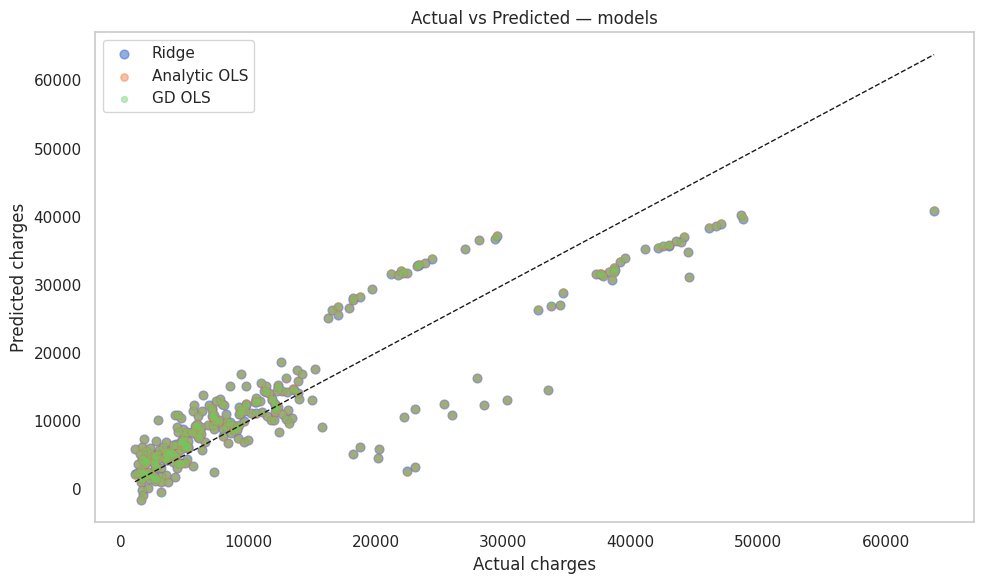

In [59]:
plt.scatter(y_test, y_pred_ridge, alpha=0.6, s=40, label='Ridge')
plt.scatter(y_test, y_pred_analytic, alpha=0.5, s=28, label='Analytic OLS')
plt.scatter(y_test, y_pred_gd, alpha=0.4, s=18, label='GD OLS')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Actual charges"); plt.ylabel("Predicted charges")
plt.legend(); plt.title("Actual vs Predicted — models")
plt.tight_layout(); plt.show()

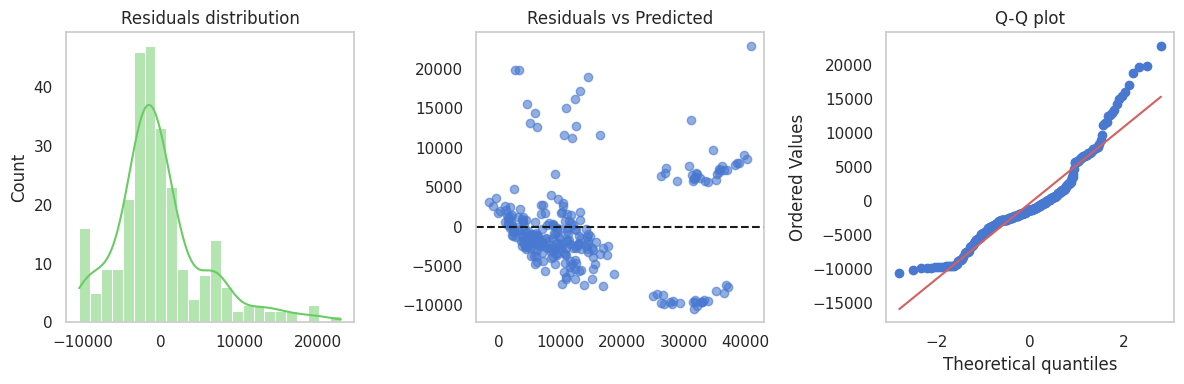

In [60]:
res = (y_test - y_pred_ridge).flatten()
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(res, kde=True, color='C2'); plt.title("Residuals distribution")
plt.subplot(1,3,2)
plt.scatter(y_pred_ridge.flatten(), res, alpha=0.6); plt.axhline(0, color='k', ls='--'); plt.title("Residuals vs Predicted")
plt.subplot(1,3,3)
stats.probplot(res, dist="norm", plot=plt); plt.title("Q-Q plot")
plt.tight_layout(); plt.show()

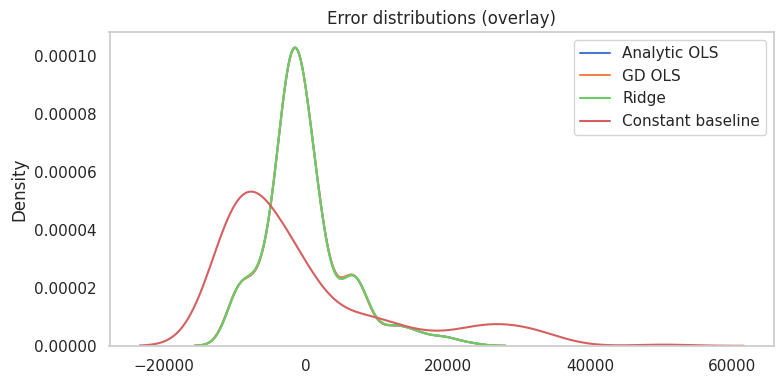

In [61]:
plt.figure(figsize=(8,4))
sns.kdeplot((y_test - y_pred_analytic).flatten(), label='Analytic OLS', bw_method=0.3)
sns.kdeplot((y_test - y_pred_gd).flatten(), label='GD OLS', bw_method=0.3)
sns.kdeplot((y_test - y_pred_ridge).flatten(), label='Ridge', bw_method=0.3)
sns.kdeplot((y_test - y_const_pred).flatten(), label='Constant baseline', bw_method=0.3)
plt.title("Error distributions (overlay)")
plt.legend(); plt.tight_layout(); plt.show()


Top absolute coefficients (Ridge):
intercept           13314.469295
smoker               9514.645885
age                  3597.525231
bmi                  2048.673301
children              512.086631
region_southwest      344.568391
region_southeast      287.469906
region_northwest      157.309401
sex                     7.115605
dtype: float64


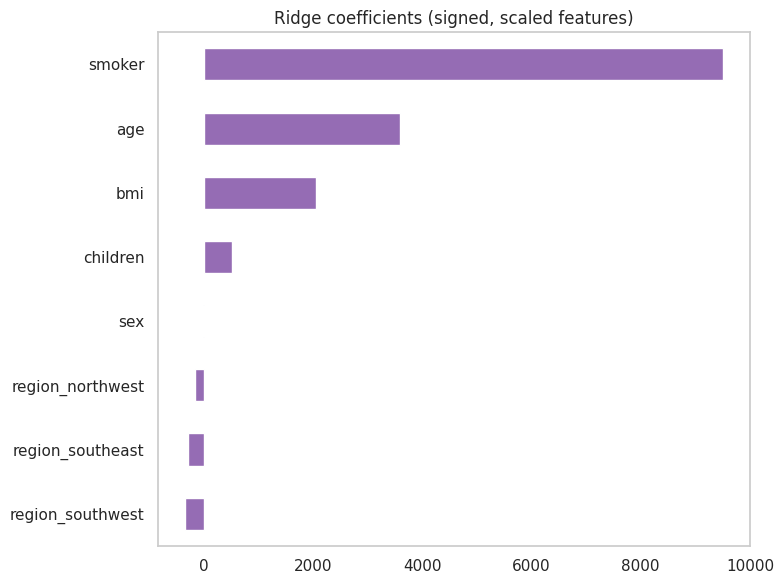

In [62]:
coef_series = pd.Series(theta_ridge.flatten(), index=feature_names)
print("\nTop absolute coefficients (Ridge):")
print(coef_series.abs().sort_values(ascending=False).head(10))

plt.figure(figsize=(8,6))
coef_series.drop('intercept').sort_values().plot(kind='barh', color='C4')
plt.title("Ridge coefficients (signed, scaled features)")
plt.tight_layout(); plt.show()